# 1. Load libraries

In [1]:
import spotipy, pandas as pd
from spotipy.oauth2 import SpotifyOAuth
from sklearn import preprocessing as pre
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import seaborn as sns
from itertools import combinations, permutations
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# 2. Spotify authorization and some sample playlists to play around with

###### One playlist below is simply my Discover Weekly, for quickly testing to make sure the code works. The other is largely my Liked Songs, which contains songs from a variety of genres (movie soundtracks to rap and others), used to find the features on which to split. If you wish to play around with choosing features based on your own playlist, simply replace the playlist url below.

In [2]:
scope = 'playlist-modify-public playlist-modify-private'
red_url = 'http://localhost:8080'
#playlist = 'https://open.spotify.com/playlist/37i9dQZEVXcD0rEV1cHpue?si=cba0a3fd1e1a47b4' #Discover Weekly
playlist = 'https://open.spotify.com/playlist/0zZlkqz8ZRPsZd0kARwia9?si=2b1315ae6d884cb5' # big test playlist

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(redirect_uri=red_url,scope=scope))
user = sp.me()['id']

# 3. Song and feature extraction

##### sp.playlist_tracks returns json-formatted information about the songs in a playlist, up to 100 at a time
##### sp.audio_features returns json-formatted audio features about a list of songs, up to 50 at a time

In [3]:
offset = 0
song_ids = []
while True:
    songs = sp.playlist_tracks(playlist_id=playlist, offset=offset, fields='items.track.id', limit=100)['items']
    if len(songs) == 0:
        break
    song_ids += [d['track']['id'] for d in songs]
    offset += len(songs)

In [4]:
offset = 0
limit = 50
song_feats = []
while offset < len(song_ids):
    song_feats += sp.audio_features(tracks=song_ids[offset: offset + limit])
    offset += limit

In [5]:
df_feats = pd.DataFrame(song_feats).drop(['type', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'key', 'time_signature', 'mode'], axis=1)

##### As a brief note, features already normed by Spotify like "energy" and "valence" are also normed below, as all songs spotify has being normed on these features does not guarantee an even distribution in the inputted playlist. For an explanation of what each feature is, see [here](https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features).

In [6]:
to_norm = df_feats[['loudness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'danceability', 'energy', 'valence']].values
scaler = pre.MinMaxScaler()
normed = scaler.fit_transform(to_norm)
df_normed = pd.DataFrame(normed).rename(columns={0: 'loudness', 1: 'tempo', 2: 'speechiness', 3: 'acousticness', 4: 'instrumentalness', 5: 'liveness', 6: 'danceability', 7: 'energy', 8: 'valence'})

In [7]:
df_feats.drop(['loudness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'danceability', 'energy', 'valence'], axis=1, inplace=True)

In [8]:
# We need the dataframe with the ids preserved later for playlist creation, and create one with song ids as the index for purposes of clustering
df_total = df_feats.join(df_normed)
df_feats = df_total.set_index('id')

# 4. Choosing features to cluster on

##### I create a correlations heatmap below. Keeping in mind some of the stronger correlations, like loudness and instrumentalness or acousticness and energy, is important when choosing features in order to avoid clustering using those feature combinations.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


<AxesSubplot:>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


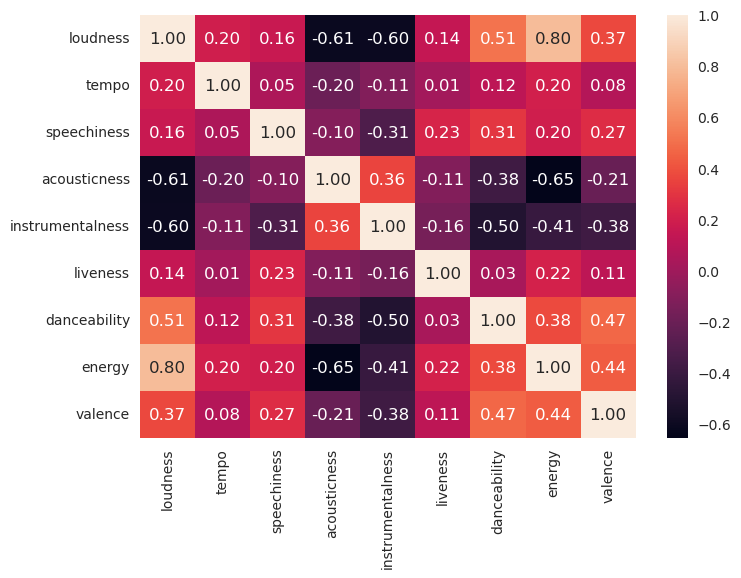

In [9]:
sns.heatmap(df_feats.corr(), annot=True, fmt='.2f')

##### The code below finds silhouette scores and elbows for clusters based on each pair of features. Clustering on 3+ features is not done simply because in testing, no clusters using 5+ features performed well. Clusters using 3 or 4 features occasionally performed decently, but were always outperformed by clusters using only 2. Often times, clusters from 3 or 4 features were outperformed by a combination of only two of the features they contained.

##### Often, the combinations that yielded the highest silhouette score only outputted two playlists. The playlists I tested on had enough variety that I felt this was not enough clusters. Splitting music in half along two features, while accurate to those two features, actively covers up some of the actual differences in the music. As such, I created the 'total' column by multiplying each combination's score and elbow. This gives some weight to the silhouette score while also rewarding clustering algorithms that found more ways to split the inputted playlist.

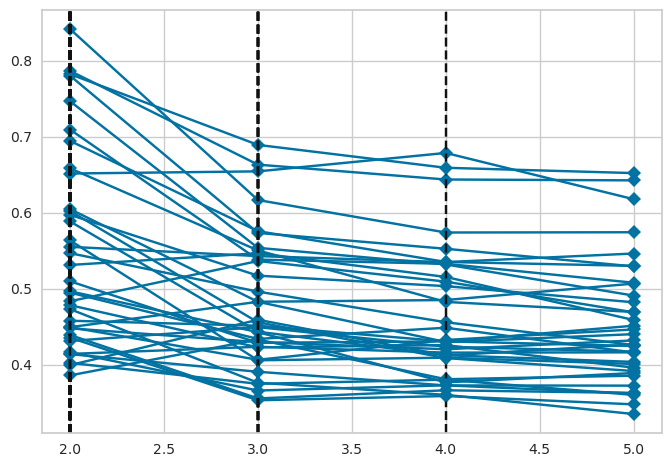

In [10]:
n_clusters = [2, 3, 4, 5, 6]
cols = list(df_feats)
score, value = [], []
combos = list(combinations(cols, 2))
for combo in combos:
    subset = df_feats[list(combo)]
    model = KElbowVisualizer(KMeans(), k=(min(n_clusters), max(n_clusters)), metric='silhouette', timings=False)
    model.fit(subset.values)
    score.append(model.elbow_score_)
    value.append(model.elbow_value_)

performance = {'score': score, 'elbow': value}
df_combos = pd.DataFrame(combos, columns=['feat_1', 'feat_2']).join(pd.DataFrame(performance))
df_combos['total'] = df_combos.apply(lambda combo: combo['score'] * combo['elbow'], axis=1)

##### Below I sort clusters by their 'total' scores. This is simply to get a sense of which clusters are performing well and to aid with choosing feature combinations to try in [app.py](app.py).

In [11]:
df_combos.sort_values(by=['total'], ascending=False).head(36)

,feat_1,feat_2,score,elbow,total
21,acousticness,instrumentalness,0.678695,4,2.714778
3,loudness,instrumentalness,0.841755,2,1.683510
1,loudness,speechiness,0.536511,3,1.609534
16,speechiness,instrumentalness,0.786749,2,1.573498
26,instrumentalness,liveness,0.782415,2,1.564829
10,tempo,instrumentalness,0.780403,2,1.560806
27,instrumentalness,danceability,0.746786,2,1.493572
32,liveness,valence,0.482866,3,1.448597
28,instrumentalness,energy,0.709483,2,1.418965
29,instrumentalness,valence,0.694566,2,1.389132


# 5. Playlist creation

##### I extract the features with the highest 'total' score below and use those to create clusters, and then playlists.

In [12]:
feat_1 = df_combos[df_combos['total']==df_combos['total'].max()]['feat_1'].values[0]
feat_2 = df_combos[df_combos['total']==df_combos['total'].max()]['feat_2'].values[0]
num_clusts = df_combos[df_combos['total']==df_combos['total'].max()]['elbow'].values[0]

df_to_cluster = df_total[['id', feat_1, feat_2]]
model = KMeans(n_clusters=num_clusts).fit(df_to_cluster[[feat_1, feat_2]].values)
clusters = {'cluster': model.labels_}
df_clustered = df_to_cluster.join(pd.DataFrame(clusters))

In [13]:
for i in range(num_clusts):
    songs = list(df_clustered['id'][df_clustered['cluster'] == i])
    name = f'created_playlist_{i}'
    current_playlists = []
    offset = 0
    while True:
        playlists = sp.current_user_playlists(limit=50, offset=offset)['items']
        if len(playlists) == 0:
            break
        current_playlists += [d['name'] for d in playlists]
        offset += len(playlists)
    if name in current_playlists:
        continue
    sp.user_playlist_create(user=user, name=name)
    new = sp.current_user_playlists(limit=1)['items'][0]['uri']
    if len(songs) > 100:
        j = 0
        while j < (len(songs)//100 + 1):
            sub_songs = songs[100*j:100*(1+j)]
            sp.user_playlist_add_tracks(user=user, playlist_id=new, tracks=sub_songs)
            j += 1
        sp.user_playlist_add_tracks(user=user, playlist_id=new, tracks=songs[-(len(songs)%100):])
    else:
        sp.user_playlist_add_tracks(user=user, playlist_id=new, tracks=songs)